# Data Analysis: YNAB Support Forums
- Sita Thomas
- NYCDSA Web Scraping Project
- July 2020
- Project Github repository: https://github.com/sitathomas/web_scraping_project

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Scraped-Data-Import" data-toc-modified-id="Scraped-Data-Import-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><strong>Scraped Data Import</strong></a></span></li><li><span><a href="#User-Stats" data-toc-modified-id="User-Stats-3"><span class="toc-item-num">3&nbsp;&nbsp;</span><strong>User Stats</strong></a></span></li><li><span><a href="#User-Lifespan" data-toc-modified-id="User-Lifespan-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>User Lifespan</a></span></li><li><span><a href="#User-Lifespan-Graphs" data-toc-modified-id="User-Lifespan-Graphs-5"><span class="toc-item-num">5&nbsp;&nbsp;</span><strong>User Lifespan Graphs</strong></a></span></li><li><span><a href="#Topic-Categories" data-toc-modified-id="Topic-Categories-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Topic Categories</a></span></li><li><span><a href="#Topic-Category-Graphs" data-toc-modified-id="Topic-Category-Graphs-7"><span class="toc-item-num">7&nbsp;&nbsp;</span><strong>Topic Category Graphs</strong></a></span></li><li><span><a href="#Average-Stats" data-toc-modified-id="Average-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span><strong>Average Stats</strong></a></span></li><li><span><a href="#Top-Stats" data-toc-modified-id="Top-Stats-9"><span class="toc-item-num">9&nbsp;&nbsp;</span><strong>Top Stats</strong></a></span></li><li><span><a href="#NLP-Pre-Processing" data-toc-modified-id="NLP-Pre-Processing-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>NLP Pre-Processing</a></span></li><li><span><a href="#Sentiment-Analysis" data-toc-modified-id="Sentiment-Analysis-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Sentiment Analysis</a></span></li><li><span><a href="#Sentiment-Analysis-Graphs" data-toc-modified-id="Sentiment-Analysis-Graphs-12"><span class="toc-item-num">12&nbsp;&nbsp;</span><strong>Sentiment Analysis Graphs</strong></a></span></li><li><span><a href="#N-grams-Function" data-toc-modified-id="N-grams-Function-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>N-grams Function</a></span></li><li><span><a href="#Text-Bigrams-Word-Cloud" data-toc-modified-id="Text-Bigrams-Word-Cloud-14"><span class="toc-item-num">14&nbsp;&nbsp;</span><strong>Text Bigrams Word Cloud</strong></a></span></li><li><span><a href="#Title-Bigrams-Word-Cloud" data-toc-modified-id="Title-Bigrams-Word-Cloud-15"><span class="toc-item-num">15&nbsp;&nbsp;</span><strong>Title Bigrams Word Cloud</strong></a></span></li><li><span><a href="#Time-Series" data-toc-modified-id="Time-Series-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Time Series</a></span></li><li><span><a href="#Bigram-WC-for-April-2020" data-toc-modified-id="Bigram-WC-for-April-2020-17"><span class="toc-item-num">17&nbsp;&nbsp;</span>Bigram WC for April 2020</a></span></li></ul></div>

## Setup

In [1]:
import numpy as np
from scipy import stats
import re
from textblob import TextBlob
from wordcloud import WordCloud
import datetime

import pandas as pd
pd.set_option('display.max_columns', None)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.graph_objs import Figure, Layout
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

## **Scraped Data Import**

**Note: There is a publicly-visible version and a full version of the YNAB support forums. In order to access the full version, one must have a paid subscription to YNAB. Therefore, this data excludes a subscription-only category of the forums, Journals, for ethical reasons. As of this scraping, the Journal category made up roughly 8% of the total number of forum posts.**

In [2]:
ynab = pd.read_csv("ynab/ynab.csv")
ynab.posted = pd.to_datetime(ynab.posted)
ynab["date"] = ynab.posted.dt.date
ynab["month"] = ynab.posted.dt.to_period("M")
ynab.month = ynab.month.apply(lambda x: x.astype('datetime64[ns]'))
ynab.columns = ynab.columns.str.replace('posted','date_time')
ynab = ynab[["category", "title", "text", "user", "likes", "replies", "views",
                "following", "date_time", "date", "month"]]
ynab.sample(5)

category                                              title  \
4287       App Functions                             Scheduled transactions   
2642  API & Integrations      API to get most recent N cleared transactions   
4445     Getting Started       Problem with initial state for big purchases   
5550       App Functions                                    Up Next Update?   
1526        Credit Cards  Difference in Credit Card "Payment" category a...   

                                                   text               user  \
4287  A collapsable list is showing up at the top of...       Hiking_Holly   
2642  I'm writing a custom script to import transact...       Salmon_Piano   
4445  I'm having trouble figuring out how to model m...      Violet_Rain.7   
5550  Currently everything on the Up Next roadmap pa...      Orange_Crab.3   
1526  Hello Everyone, Long time listener, first time...  Sky_Blue_Welder.2   

      likes  replies  views  following           date_time        date  \
4287      0        5    114        5.0 2019-08-24 07:58:00  2019-08-24   
2642      0        1    118        2.0 2019-01-02 03:14:00  2019-01-02   
4445      0        4    102        4.0 2019-07-26 02:59:00  2019-07-26   
5550      3        1    102        2.0 2020-01-14 08:11:00  2020-01-14   
1526      0        5    703        4.0 2018-05-14 07:51:00  2018-05-14   

          month  
4287 2019-08-01  
2642 2019-01-01  
4445 2019-07-01  
5550 2020-01-01  
1526 2018-05-01

## **User Stats**

In [3]:
posts_by_user = pd.DataFrame(ynab.groupby("user").size()).sort_values(0, ascending=False).reset_index()
posts_by_user.columns = ["user", "posts"]
posts_by_user["ratio"] = round(posts_by_user["posts"] / len(ynab), 3)

print("Number of posts:", len(ynab))
print("Number of unique users:", len(set(ynab.user)))
print("Ratio of unique users:", round(len(set(ynab.user)) / len(ynab.user), 2))
print("Average posts per user:", round(len(ynab) / len(set(ynab.user)), 2))
print("Top 10 Users:", "\n", posts_by_user[:10])

Number of posts: 7142
Number of unique users: 4629
Ratio of unique users: 0.65
Average posts per user: 1.54
Top 10 Users: 
                       user  posts  ratio
0            Khaki_Storm.1     64  0.009
1                    MXMOM     44  0.006
2  Tomato_Mask_05bd62cee89     42  0.006
3           Maroon_Admiral     29  0.004
4            Green_Nomad.7     26  0.004
5                 iwaddo77     25  0.004
6              Maroon_Mill     22  0.003
7          Sky_Blue_Harp.2     21  0.003
8            Salmon_Case.2     20  0.003
9        Turquoise_Major.5     19  0.003


## User Lifespan

In [4]:
lifespan = ynab.groupby(["user"], as_index=False).agg({"date": ["min", "max"]})
lifespan.columns = lifespan.columns.to_flat_index()
lifespan.columns = ["user", "first_post", "last_post"]
lifespan["duration"] = (lifespan.last_post - lifespan.first_post).dt.days // 30.4 # duration in months
lifespan = pd.merge(lifespan, posts_by_user, on="user")

# All user lifespans
lifespan_graph = px.scatter(lifespan.groupby("duration").count().reset_index(), x="duration", y="user", size="user", size_max=40,
                 title="User Lifespan in Months")

users_by_post = go.Figure()
users_by_post.update_layout(title="Non-Rollover Users by Post Count", xaxis=dict(title="posts"),
                  yaxis=dict(title="user"))

# Users with duration 0 (duration > a day but less than a month)
brief_users = lifespan.loc[(lifespan.last_post > lifespan.first_post) & (lifespan.duration == 0)]
brief_dur = brief_users.groupby("posts").count().reset_index()
users_by_post.add_trace(go.Scatter(x=brief_dur.posts, y=brief_dur.user,
                    mode='markers',
                    marker=dict(size=brief_dur.user, sizemode="area", sizemin=2),
                    name='< 1-month Duration'))

# 1-day users
non_rep_lifespan = lifespan.loc[lifespan.first_post == lifespan.last_post]
non_rep_dur = non_rep_lifespan.groupby("posts").count().reset_index()
users_by_post.add_trace(go.Scatter(x=non_rep_dur.posts, y=non_rep_dur.user,
                    mode='markers',
                    marker=dict(size=non_rep_dur.user, sizemode="area"),
                    name='1-day Duration'))

# Users with duration >= 1 (duration one month or longer)
rollover_users = lifespan.loc[(lifespan.last_post > lifespan.first_post) & (lifespan.duration >= 1)]
rollover_dur = rollover_users.groupby("duration").count().reset_index()
rollover_dur["year_plus_users"] = rollover_dur.duration > 12.0
rollover_graph = px.scatter(rollover_dur, x="duration", y="user", size="user", size_max=40,
                 color="year_plus_users", title="Rollover User Lifespan in Months")

## **User Lifespan Graphs**

In [5]:
print("Newest post:", ynab.date_time.max())
print("Oldest post:", ynab.date_time.min())

lifespan_graph.show()
users_by_post.show()
rollover_graph.show()

print("Number of Users Active 1 Day:", non_rep_dur.user.sum())
print("Number of Users Active 2 days to 1 Month:", brief_dur.user.sum())
print("Number of Users Active Beyond 1 Month:", rollover_dur.user.sum())
print("Number of Users Active Beyond 1 Year:",
      rollover_dur.user.sum() - rollover_dur.loc[rollover_dur.year_plus_users == True].user.sum())

Newest post: 2020-06-17 12:47:00
Oldest post: 2017-10-26 01:50:00


Number of Users Active 1 Day: 3700
Number of Users Active 2 days to 1 Month: 282
Number of Users Active Beyond 1 Month: 646
Number of Users Active Beyond 1 Year: 477


The vast majority of users, by thousands, only post on the forums once. Of users that post multiple times up to one month, the majority only post twice. Of rollover users (users that experience the transition from one month to the next in YNAB), most stop posting within a year.

I did not have access to subscription data, which could be used to determine if forum participation is correlated with subscription activity. If so, it would be beneficial for YNAB to encourage forum use in order to retain users.

## Topic Categories

In [6]:
def build_cat_stats(field):
  return ynab.groupby("category")[field].sum()
category_stats = pd.concat([ynab.category.value_counts(), build_cat_stats("likes"),
                            build_cat_stats("replies"), build_cat_stats("views"),
                            build_cat_stats("following")], axis=1)
category_stats.columns.values[0] = "posts"
category_stats["category"] = category_stats.index
category_stats.index = range(0, len(category_stats))

def build_cat_ratios(field):
  category_stats["{}_ratio".format(field)] = 0
  new_cells = []
  for cell in category_stats[field]:
    new_cells.append(round(cell / category_stats[field].sum(), 3))
  category_stats["{}_ratio".format(field[0][0])] = new_cells
category_stats = pd.concat([category_stats, build_cat_ratios("posts"), build_cat_ratios("likes"),
                            build_cat_ratios("replies"), build_cat_ratios("views"),
                            build_cat_ratios("following")])

category_stats = category_stats[["category", "posts", "p_ratio", "likes", "l_ratio", "replies",
                                 "r_ratio", "views", "v_ratio", "following", "f_ratio"]]

interactions_graph = go.Figure()
def interaction_ratios(ratio, field):
    interactions_graph.add_trace(go.Scatter(
        x=category_stats["{}_ratio".format(ratio)].values,
        y=category_stats.category,
        name=field
        )
    )
interaction_ratios("l", "likes")
interaction_ratios("r", "replies")
interaction_ratios("v", "views")
interaction_ratios("f", "following")
interactions_graph.update_traces(mode='markers', marker=dict(line_width=1, symbol='circle', size=16))
interactions_graph.update_layout(
    title="Post Interaction Ratios Per Category",
    xaxis=dict(
        ticks='outside',
    ),
    yaxis=dict(
        ticks='outside',
    )
)

topic_graph = px.pie(category_stats, values='posts', names=list(category_stats.category), title='Posts Per Category')

## **Topic Category Graphs**

In [7]:
topic_graph.show()
interactions_graph.show()

The six categories with the highest number of posts also have the highest interaction ratios, with the exception of Likes.
These categories all regard either technical aspects of the software or the YNAB methodology in very general ways, while most of the other categories cover special use cases.

More encouragement of users to discuss those special use cases could improve user engagement, and marketing those specifically toward potential subscribers could bring in a broader variety of users, as well as new and under-tapped markets. This information is also useful for assessing current software features and educational materials - common topics in the top six categories indicate areas for improvement.

In [137]:
def z_scores(df, field):
    return pd.DataFrame({field: stats.zscore(df[field])}).set_index(df.category)

zscore_df = pd.concat([z_scores(category_stats, "posts"), z_scores(category_stats, "likes"),
                       z_scores(category_stats, "replies"), z_scores(category_stats, "views"),
                       z_scores(category_stats, "following")], axis=1)

zscore_df.where(abs(zscore_df) > 2).dropna(how="all")

posts     likes   replies    views  following
category                                                                 
Accounts & Transactions  2.612543       NaN  2.080624      NaN   2.234699
Method & Budgeting       2.013988       NaN  2.331432  2.17439   2.256006
YNAB Wins                     NaN  3.939579       NaN      NaN        NaN

# ***The above categories are more than two standard deviations from the mean of that interaction type, so they can be assessed for what makes them popular.***

## **Average Stats**

In [9]:
def avg_stats(field):
  print("Average {}:".format(field), round(ynab.sort_values(field, ascending=False)[field].mean(), 2))
avg_stats("likes")
avg_stats("replies")
avg_stats("views")
avg_stats("following")

Average likes: 0.88
Average replies: 8.83
Average views: 529.22
Average following: 5.08


How can averages be increased? Do greater interactions per user indicate a longer relationship with the forums and therefore presumably a longer subscription?

## **Top Stats**

In [10]:
def top_stats(field):
  top_post = ynab.sort_values(field, ascending=False)
  print("Most {}:".format(field), top_post[field].iloc[0], "\n",
        top_post.iloc[0][["category", "title"]], "\n")
top_stats("likes")
top_stats("replies")
top_stats("views")
top_stats("following")

Most likes: 101 
 category            Community Challenges
title       official 2020 debt smackdown
Name: 6808, dtype: object 

Most replies: 2575 
 category            Community Challenges
title       official 2020 debt smackdown
Name: 6808, dtype: object 

Most views: 26420 
 category                YNAB Wins
title       improve finance today
Name: 6825, dtype: object 

Most following: 365.0 
 category            Community Challenges
title       official 2020 debt smackdown
Name: 6808, dtype: object 



## NLP Pre-Processing

In [8]:
stop_words = stopwords.words('english') + \
    ["budget", "budgets", "budgeting", "budgeted", "ynab", "account", "accounts", "transaction",
     "transactions", "money", "category", "categories", "thank", "thanks", "make", "one", "way",
     "need", "want", "anyone", "know", "help", "question", "really", "still", "always", "hi",
     "hello", "thing", "http", "https", "www", "youneedabudget", "etc"]

def nlp_preprocess(field):
    # Clean text
    field = field.str.lower()
    field = field.apply(lambda x: re.sub('[^\w\s]', ' ', x))
    field = field.apply(lambda x: " ".join(word for word in x.split() if word not in stop_words))

    # Lemmatize
    field = field.apply(lambda x: ' '.join([WordNetLemmatizer().lemmatize(word) for word in x.split()]))

    # Tokenize
    tokens = field.apply(lambda x: word_tokenize(x))
    field = tokens.apply(lambda x: " ".join(sorted(set(x), key=x.index)))
    return field
    

ynab.text = nlp_preprocess(ynab.text)
ynab.title = nlp_preprocess(ynab.title)

## Sentiment Analysis

In [11]:
def sentiment_analysis(x):
    sentiment = TextBlob(x.text)
    x['polarity'] = sentiment.polarity
    x['subjectivity'] = sentiment.subjectivity
    return x

ynab_sa = ynab.apply(sentiment_analysis, axis=1)

In [12]:
sentiment_graph = make_subplots(rows=2, cols=4)

def build_sentiment_graph(sentiment, field, row, col):
    sentiment_graph.add_trace(go.Scatter(
        x=ynab_sa[sentiment],
        y=ynab_sa[field],
        name="{}: {}".format(sentiment, field)
        ),
        row=row,
        col=col
    )
build_sentiment_graph("polarity", "likes", 1, 1)
build_sentiment_graph("polarity", "replies", 1, 2)
build_sentiment_graph("polarity", "views", 1, 3)
build_sentiment_graph("polarity", "following", 1, 4)
build_sentiment_graph("subjectivity", "likes", 2, 1)
build_sentiment_graph("subjectivity", "replies", 2, 2)
build_sentiment_graph("subjectivity", "views", 2, 3)
build_sentiment_graph("subjectivity", "following", 2, 4)

sentiment_graph.update_traces(mode='markers')

sentiment_graph.update_layout(
    title="Sentiment Analysis",
    xaxis=dict(
        ticks='outside',
    ),
    yaxis=dict(
        ticks='outside',
    )
)

## **Sentiment Analysis Graphs**

In [13]:
sentiment_graph.show()

Subjectivity isn't correlated with post interactions, but positive posts do tend to garner more interactions.

## N-grams Function

In [14]:
stop_bigrams = ["would_like", "would_nice", "even_though", "feel_like", "look_like", "go_back", "long_time",
                "started_using", "missing_something", "something_like", "something_wrong", "something_bad",
                "bad_happened", "text_think", "time_first", "would_love", "would_appreciated",
                "greatly_appreciated", "head_around", "get_back", "let_say", "can_not", "make_sense",
                "trying_figure", "trying_get", "thing_like", "seems_like", "e_g", "every_time",
                "using_year", "get_rid", "thought_would", "day_ago", "0_00", "1_2", "youneedabudget_com",
                "new_user", "brand_new", "using_since"]

def n_grams(field, n, stop_list):
    new_col = field.apply(lambda x: TextBlob(x).ngrams(n))
    new_col = new_col.apply(lambda x: ['_'.join(grams) for grams in x])
    new_col = new_col.apply(lambda x: ' '.join(x))
    new_col = new_col.apply(lambda x: ' '.join(word for word in x.split() if word not in stop_list))
    ynab["{}_ngrams".format(field.name)] = new_col
    
n_grams(ynab.text, 2, stop_bigrams)
n_grams(ynab.title, 2, stop_bigrams)

## **Text Bigrams Word Cloud**

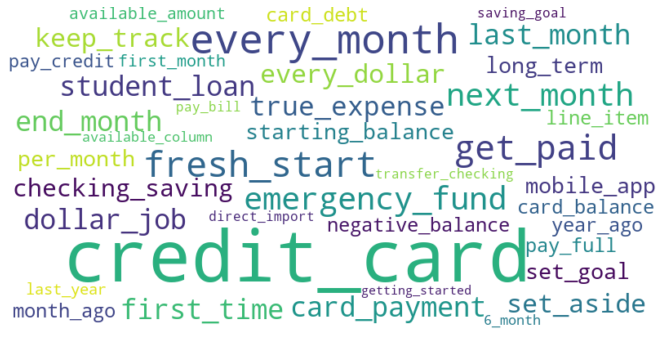

In [15]:
wc = WordCloud(background_color="white", max_words=40, width=800, height=400, collocations=False)

wc.generate(" ".join(ynab.text_ngrams))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

A lot of the posts seems to discuss credit cards - "credit card, pay credit, use credit, card debt, card payment, card balance." The word cloud indicates that credit cards are a popular source of discussion - marketing could be targeted toward people looking to manage their credit cards. It also potentially indicates that credit cards may be a source of confusion to users, and may be a software feature to improve.
 
Another common bigram is "fresh start," which is a feature of the YNAB software that users often utilize when they are confused by their budget or have a major life event that significantly alters their budget. Further text analysis, to explore why users implement Fresh Start, may be useful. If users Fresh Start mostly out of frustration, the risk of losing users may increase.

Other topics of interest indicated by the word cloud include emergency funds, student loans, True Expenses, and goals (set, monthly, saving). True Expenses are part of the YNAB methodology, and are usually bills that occur less than monthly. Goals are subjective user goals, but also a software feature. All of these topics can be areas for targeted marketing as well as educational content.

## **Title Bigrams Word Cloud**

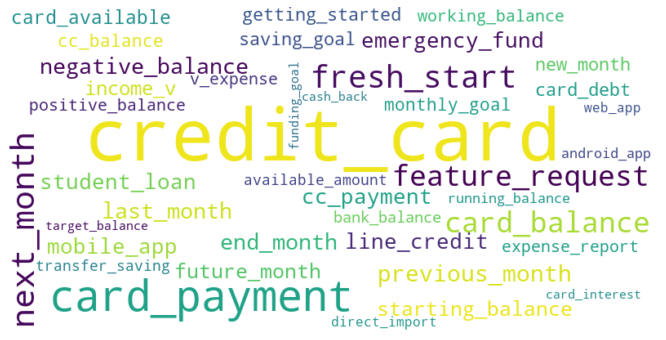

In [16]:
wc.generate(" ".join(ynab.title_ngrams))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

## Time Series

In [28]:
print("Newest post:", ynab.date_time.max())
print("Oldest post:", ynab.date_time.min())

Newest post: 2020-06-17 12:47:00
Oldest post: 2017-10-26 01:50:00


In [93]:
posts_by_month = ynab.groupby("month").count().reset_index()[["month", "date_time"]]

fig = px.line(posts_by_month, x=posts_by_month.index, y="date_time", title="Posts per Month")
fig.show()

monthly_diff = posts_by_month.diff()
monthly_diff = monthly_diff.loc[1:,]
monthly_diff["z_score"] = stats.zscore(monthly_diff.date_time)
monthly_diff.loc[monthly_diff.z_score > 2]

month  date_time   z_score
1  31 days      138.0  2.033944
2      NaT        NaN       NaN
3      NaT        NaN       NaN
4      NaT        NaN       NaN
5      NaT        NaN       NaN
6      NaT        NaN       NaN
7      NaT        NaN       NaN
8      NaT        NaN       NaN
9      NaT        NaN       NaN
10     NaT        NaN       NaN
11     NaT        NaN       NaN
12     NaT        NaN       NaN
13     NaT        NaN       NaN
14     NaT        NaN       NaN
15     NaT        NaN       NaN
16     NaT        NaN       NaN
17     NaT        NaN       NaN
18     NaT        NaN       NaN
19     NaT        NaN       NaN
20     NaT        NaN       NaN
21     NaT        NaN       NaN
22     NaT        NaN       NaN
23     NaT        NaN       NaN
24     NaT        NaN       NaN
25     NaT        NaN       NaN
26     NaT        NaN       NaN
27     NaT        NaN       NaN
28     NaT        NaN       NaN
29     NaT        NaN       NaN
30     NaT        NaN       NaN
31 30 days      138.0  2.033944
32     NaT        NaN       NaN

The jump from April 2020 to May 2020 may at first glance seem to be due to COVID-19 and its economic impacts, however the word cloud below indicates that it's more likely due to problems automatically importing transactions from banking institutions.

## Bigram WC for April 2020

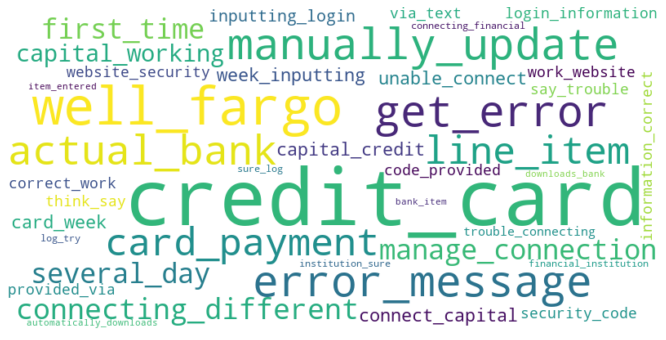

In [30]:
ynab_exp = pd.merge(ynab, category_stats[["category", "p_ratio", "l_ratio",
                                          "r_ratio", "v_ratio", "f_ratio"]], how="outer", on="category")
ynab_exp.loc[ynab_exp.month=="2020-04-01"].groupby("category").sum().sort_values("p_ratio", ascending=False)

wc.generate(' '.join(ynab.loc[(ynab.month=="2020-04-01") & \
                              (ynab.category=="Accounts & Transactions"),:].text_ngrams))
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()